<a href="https://colab.research.google.com/github/orekhovsky/ITMO_Masters/blob/main/Introduction%20%26%20Advanced%20ML/Clustering/Clustering_GM_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генеративная модель на основе гауссовых смесей

Гауссовы смеси — естественное математическое обобщение алгоритма `K-means`. По сути, подход ищет не просто какие-то кучки вокруг формирующихся центроидов, а некоторую смесь многомерных нормальных распределений (по сути — тоже кучки вокруг средних со своими дисперсиями). Так как такой подход оценивает плотности распределений, то он часто используется в задачах KDE (kernel density estimation). В том числе, он может быть применен к задаче генерации: если есть плотность распределения, то можно семплировать и получать новые объекты. Давайте посмотрим на простейший пример решения такой задачи.

Работать будем опять-таки с `MNIST`. Так как модель оказывается крайне тяжеловесной, будем использовать «простой» набор данных. Визуализируем элементы этого набора данных (для наглядности)

In [4]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from google.colab.patches import cv2_imshow
from keras.datasets import mnist

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


%matplotlib inline

In [2]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
digits.data.shape

(1797, 64)

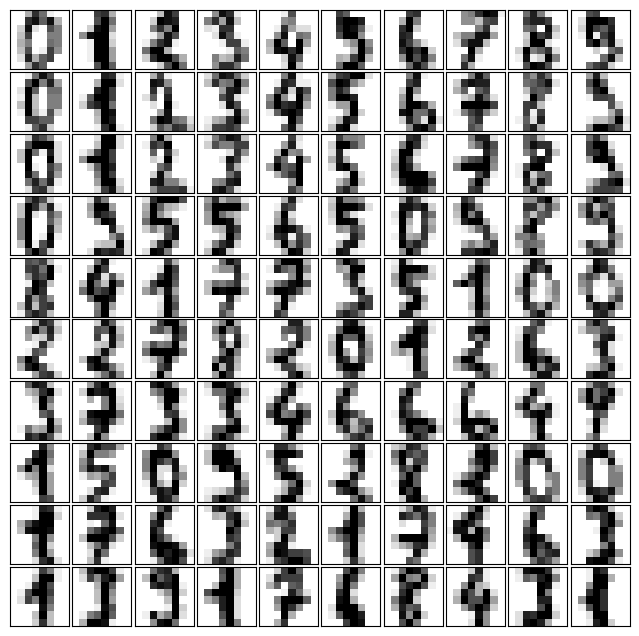

In [3]:
fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for i, axi in enumerate(ax.flat):
    im = axi.imshow(digits.data[i].reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

Для того, чтобы обучение проходило быстрее имеет смысл снизить размерность пространства признаков. Произведите преобразования для всего набора данных помощи <code>PCA(n_components=0.99, svd_solver=='full')</code>.


In [5]:
pca = PCA(n_components=0.99, svd_solver='full')
transformed_data = pca.fit_transform(digits.data)


Введите число полученных ГК

In [6]:
print("Number of PC: ", pca.components_.shape[0])

Number of PC:  41


Обучим интересующую нас модель, подобрав гиперпараметр, отвечающий за число используемых компонент, минимизируя <a href="https://ru.wikipedia.org/wiki/Информационный_критерий_Акаике">информационный критерий Акаике</a>.

Для значений параметра <code>n_components</code> в диапазоне $[50,250)$ с шагом $10$ обучите модели <a href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html"><code>GaussianMixture</code></a> с параметрами, указанными в вашем задании. При помоши метода <code>.aic()</code> вычислите значение критерия каждой модели.

Введите значение <code>n_components</code> модели с наименьшим значением критерия Акаике.




In [8]:
for n_comp in range(50, 250, 10):
  gm = GaussianMixture(n_components=n_comp, covariance_type='full', random_state=41).fit(transformed_data)
  metric = gm.aic(transformed_data)
  if n_comp == 50:
    best_metric = metric
    best_n = n_comp
  else:
    if metric < best_metric:
      best_metric = metric
      best_n = n_comp
print("Best n_comp: ", best_n)
print("Best metric: ", best_metric)

Best n_comp:  200
Best metric:  -191103.99291240133


Обучите финальную модель на подобранном гиперпараметре. Проверьте, что обучение сошлось (поле <code>.converged_</code> модели).

In [14]:
gm = GaussianMixture(n_components=best_n, covariance_type='full', random_state=41).fit(transformed_data)
print("Converged: ", gm.converged_)

Converged:  True


При помощи метода <code>.sample()</code> сгенерируйте $100$ новых объектов.

Введите выборочное среднее коориднаты с индексом $0$ сгенерированных объектов.

In [15]:
X_gen, y_gen = gm.sample(100)
print("Mean 0-PC value: ", np.mean(X_gen[:,0]))

Mean 0-PC value:  1.3917235910719756


При помоши метода <code>.inverse_transform()</code> класса <code>PCA</code> верните сгенерированные объекты в пространство исходных признаков.

In [16]:
X_gen_inv_transform = pca.inverse_transform(X_gen)

Визуализируйте полученные результаты. Введите номер изображения, соответствующего сгенерированному объекту с индексом $5$ (индексация начинается с нуля)

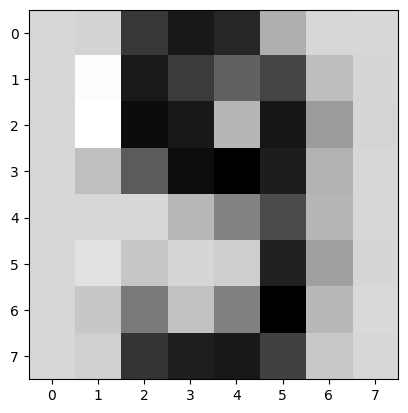

In [18]:
plt.imshow(X_gen_inv_transform[17].reshape(8,8),cmap='binary')